In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

from tqdm.notebook import tqdm

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ROOT_DIR = '/content/drive/MyDrive'
TRAIN_SAVE_PATH = '/content/drive/MyDrive/MNIST_SAVE'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 데이터 전처리

In [5]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),  # 데이터 증강: 무작위로 10도 회전
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
train_dataset = datasets.MNIST(root=ROOT_DIR, train=True, download=True, transform=train_transform)
test_dataset = datasets.MNIST(root=ROOT_DIR, train=False, download=True, transform=test_transform)

In [7]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [8]:
BATCH_SIZE = 64

In [9]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 모델링

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 컨볼루션 레이어
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # 완전 연결 레이어
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

        # 활성화 함수 및 풀링 레이어
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(-1, 32 * 7 * 7) # 이미지를 1차원으로 평탄화
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
model = CNN().to(device) # 모델을 GPU 메모리에 올립니다.
print(model)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


# 학습

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
def train(model, loader, criterion, optimizer, epochs=5):
    loss_hist = []
    best_train_loss = float('inf')

    for epoch in tqdm(range(epochs)):
        model.train()
        epoch_loss = 0  # ✅ 에포크 시작할 때 초기화

        for i, (images, labels) in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}")):
            image, label = images.to(device), labels.to(device)

            # 순전파, 손실 계산, 역전파
            outputs = model(image)
            loss = criterion(outputs, label)

            # 옵티마이저 초기화 및 업데이트
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(loader)}], Loss: {loss.item():.4f}')

        # 에포크 평균 손실 저장 (총합 / 배치 개수)
        avg_loss = epoch_loss / len(loader)
        loss_hist.append(avg_loss)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

        # 모델 저장 (item() 비교해야 함)
        if avg_loss < best_train_loss:
            best_train_loss = avg_loss
            torch.save(model.state_dict(), f'{TRAIN_SAVE_PATH}/best_cnn.pt')

    return loss_hist

In [27]:
train_loss_hist = train(model, train_loader, criterion, optimizer, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/10], Step [100/938], Loss: 0.0014
Epoch [1/10], Step [200/938], Loss: 0.0107
Epoch [1/10], Step [300/938], Loss: 0.0026
Epoch [1/10], Step [400/938], Loss: 0.0054
Epoch [1/10], Step [500/938], Loss: 0.0261
Epoch [1/10], Step [600/938], Loss: 0.0055
Epoch [1/10], Step [700/938], Loss: 0.0413
Epoch [1/10], Step [800/938], Loss: 0.0624
Epoch [1/10], Step [900/938], Loss: 0.0021
Epoch 1, Average Loss: 0.0170


Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/10], Step [100/938], Loss: 0.0257
Epoch [2/10], Step [200/938], Loss: 0.0028
Epoch [2/10], Step [300/938], Loss: 0.0088
Epoch [2/10], Step [400/938], Loss: 0.0063
Epoch [2/10], Step [500/938], Loss: 0.0051
Epoch [2/10], Step [600/938], Loss: 0.1146
Epoch [2/10], Step [700/938], Loss: 0.0863
Epoch [2/10], Step [800/938], Loss: 0.1456
Epoch [2/10], Step [900/938], Loss: 0.0432
Epoch 2, Average Loss: 0.0169


Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/10], Step [100/938], Loss: 0.0267
Epoch [3/10], Step [200/938], Loss: 0.0019
Epoch [3/10], Step [300/938], Loss: 0.0253
Epoch [3/10], Step [400/938], Loss: 0.0065
Epoch [3/10], Step [500/938], Loss: 0.0003
Epoch [3/10], Step [600/938], Loss: 0.0006
Epoch [3/10], Step [700/938], Loss: 0.1314
Epoch [3/10], Step [800/938], Loss: 0.0002
Epoch [3/10], Step [900/938], Loss: 0.0006
Epoch 3, Average Loss: 0.0153


Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/10], Step [100/938], Loss: 0.0006
Epoch [4/10], Step [200/938], Loss: 0.0038
Epoch [4/10], Step [300/938], Loss: 0.0121
Epoch [4/10], Step [400/938], Loss: 0.0036
Epoch [4/10], Step [500/938], Loss: 0.0112
Epoch [4/10], Step [600/938], Loss: 0.0002
Epoch [4/10], Step [700/938], Loss: 0.0570
Epoch [4/10], Step [800/938], Loss: 0.0035
Epoch [4/10], Step [900/938], Loss: 0.0537
Epoch 4, Average Loss: 0.0148


Epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/10], Step [100/938], Loss: 0.0026
Epoch [5/10], Step [200/938], Loss: 0.0005
Epoch [5/10], Step [300/938], Loss: 0.0001
Epoch [5/10], Step [400/938], Loss: 0.0004
Epoch [5/10], Step [500/938], Loss: 0.0008
Epoch [5/10], Step [600/938], Loss: 0.0587
Epoch [5/10], Step [700/938], Loss: 0.0065
Epoch [5/10], Step [800/938], Loss: 0.0001
Epoch [5/10], Step [900/938], Loss: 0.0051
Epoch 5, Average Loss: 0.0124


Epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [6/10], Step [100/938], Loss: 0.0480
Epoch [6/10], Step [200/938], Loss: 0.1146
Epoch [6/10], Step [300/938], Loss: 0.0181
Epoch [6/10], Step [400/938], Loss: 0.0112
Epoch [6/10], Step [500/938], Loss: 0.0005
Epoch [6/10], Step [600/938], Loss: 0.0144
Epoch [6/10], Step [700/938], Loss: 0.0039
Epoch [6/10], Step [800/938], Loss: 0.0013
Epoch [6/10], Step [900/938], Loss: 0.1181
Epoch 6, Average Loss: 0.0129


Epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [7/10], Step [100/938], Loss: 0.0060
Epoch [7/10], Step [200/938], Loss: 0.0133
Epoch [7/10], Step [300/938], Loss: 0.0002
Epoch [7/10], Step [400/938], Loss: 0.0042
Epoch [7/10], Step [500/938], Loss: 0.0017
Epoch [7/10], Step [600/938], Loss: 0.0000
Epoch [7/10], Step [700/938], Loss: 0.0025
Epoch [7/10], Step [800/938], Loss: 0.0044
Epoch [7/10], Step [900/938], Loss: 0.0509
Epoch 7, Average Loss: 0.0116


Epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [8/10], Step [100/938], Loss: 0.0010
Epoch [8/10], Step [200/938], Loss: 0.0266
Epoch [8/10], Step [300/938], Loss: 0.0015
Epoch [8/10], Step [400/938], Loss: 0.0147
Epoch [8/10], Step [500/938], Loss: 0.0496
Epoch [8/10], Step [600/938], Loss: 0.0009
Epoch [8/10], Step [700/938], Loss: 0.0013
Epoch [8/10], Step [800/938], Loss: 0.0001
Epoch [8/10], Step [900/938], Loss: 0.0004
Epoch 8, Average Loss: 0.0114


Epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [9/10], Step [100/938], Loss: 0.0001
Epoch [9/10], Step [200/938], Loss: 0.0021
Epoch [9/10], Step [300/938], Loss: 0.0007
Epoch [9/10], Step [400/938], Loss: 0.0028
Epoch [9/10], Step [500/938], Loss: 0.0004
Epoch [9/10], Step [600/938], Loss: 0.0108
Epoch [9/10], Step [700/938], Loss: 0.0006
Epoch [9/10], Step [800/938], Loss: 0.0033
Epoch [9/10], Step [900/938], Loss: 0.0005
Epoch 9, Average Loss: 0.0102


Epoch 10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [10/10], Step [100/938], Loss: 0.0002
Epoch [10/10], Step [200/938], Loss: 0.0001
Epoch [10/10], Step [300/938], Loss: 0.0000
Epoch [10/10], Step [400/938], Loss: 0.0019
Epoch [10/10], Step [500/938], Loss: 0.0084
Epoch [10/10], Step [600/938], Loss: 0.0005
Epoch [10/10], Step [700/938], Loss: 0.0008
Epoch [10/10], Step [800/938], Loss: 0.0276
Epoch [10/10], Step [900/938], Loss: 0.0039
Epoch 10, Average Loss: 0.0103


In [28]:
def show_plot(datas):
    plt.figure(figsize=(8,5))
    plt.plot(datas, marker='o')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.grid(True)
    plt.show()

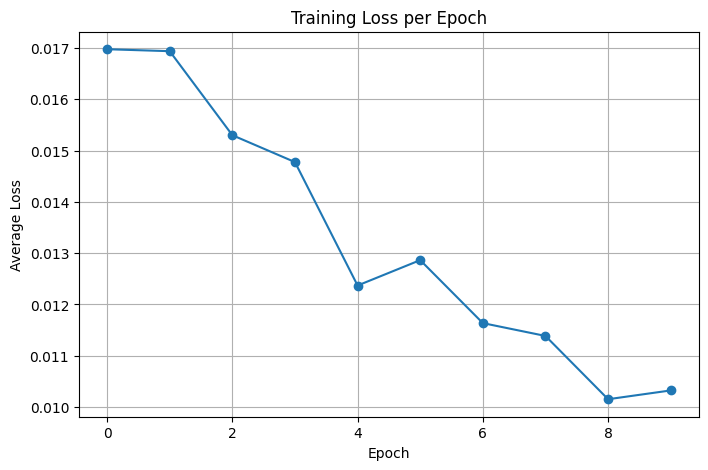

In [29]:
show_plot(train_loss_hist)